# Model Evaluation

In this notebook, we will test multiple model and evaluate to choose the best one.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [27]:
# Importing data
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
We will split the train data once more. It's because this is a competition dataset and we actually don't have the 'test' score result. So we will use the test set we created from the initial training set as a holdout set to actually see our performance of the final model. The final test set, which we don't have the labels for, will be used to make a prediction in the final testing notebook. 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

## Preprocessing
We will be utilizing mostly KNN and tree-based algorithms. We will first turn categorical features to binary dummies.

In [29]:
# Turning all categorical features to dummies 
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [30]:
# Check if training and testing sets have the same features
if X_train.shape[1] != X_test.shape[1]:
    print('only in train:', [x for x in X_train.columns if x not in X_test.columns])
    print('only in test:',[x for x in X_test.columns if x not in X_train.columns])
else: 
    print ('Good to go')

Good to go


In [9]:
# If they are not the same, add the column with 0s and fix the order
# X_test[colname] = 0
# X_test = X_test[X_train.columns]

## Class Imbalance Issue
Our dataset has high class imbalance issue. We will mostly deal with this by setting the class weight within each model, but in some cases where imbalance weight is not adequately dealt with by algorithm we test with resampled set using SMOTE.

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

## Evaluation Metrics
Our target is multi-class with imbalance issue. To focus on the imbalance of minority classes, we will also look at the macro f1 score to capture the predictive performance for overall classes. It calculates the f1 score for each class and find the average so naturally take class imbalance into account.

In [33]:
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, plot_confusion_matrix, classification_report

## Feature Selection
To optimize the process, I will subset features based on a few random decision trees.

In [34]:
original_feats = X_train.columns
len(original_feats)

440

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [36]:
etc = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state = 23)
etc = etc.fit(X_train, y_train)
model = SelectFromModel(etc, prefit=True, threshold = 1e-4)

In [37]:
X_train_new = model.transform(X_train)
new_feats = original_feats[model.get_support()]

In [38]:
len(new_feats)

393

In [39]:
X_test_new = model.transform(X_test)

In [40]:
X_train = X_train_new
X_test = X_test_new

### Standardization
Since we will be testing kNN, all feature values need to be standardized.

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test= scale.transform(X_test)

In [43]:
# Save out train/validation 
mod = open('PKL/new_feats.pkl', 'wb')
pickle.dump(new_feats, mod)
mod.close()

mod = open('PKL/TRAIN_X_train.pkl', 'wb')
pickle.dump(X_train, mod)
mod.close()

mod = open('PKL/TRAIN_X_test.pkl', 'wb')
pickle.dump(X_test, mod)
mod.close()

mod = open('PKL/TRAIN_Y_train.pkl', 'wb')
pickle.dump(y_train, mod)
mod.close()

mod = open('PKL/TRAIN_Y_test.pkl', 'wb')
pickle.dump(y_test, mod)
mod.close()

In [2]:
# reload
X_train = pickle.load(open('PKL/TRAIN_X_train.pkl', 'rb'))
X_test = pickle.load(open('PKL/TRAIN_X_test.pkl', 'rb'))
y_train = pickle.load(open('PKL/TRAIN_Y_train.pkl', 'rb'))
y_test = pickle.load(open('PKL/TRAIN_Y_test.pkl', 'rb'))

## Dummy Classifier
We'll first create a dummy classifier as a baseline score.

In [44]:
scorer = {}

In [45]:
from sklearn.dummy import DummyClassifier

In [46]:
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train, y_train)
y_pred = dummyc.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 3)
f1_test = round(f1_score(y_test, y_pred, average = 'macro'), 3)
ck_test = round(cohen_kappa_score(y_test, y_pred), 3)
print('Accuracy: ', accuracy, 'Test F1 score: ', f1_test, '/ Cohen Kappa: ', ck_test)
scorer['dummy'] = (accuracy, f1_test, ck_test)

Accuracy:  0.33 Test F1 score:  0.294 / Cohen Kappa:  -0.006


                         precision    recall  f1-score   support

             functional       0.54      0.33      0.41      4822
functional needs repair       0.07      0.32      0.12       678
         non functional       0.38      0.33      0.35      3410

               accuracy                           0.33      8910
              macro avg       0.33      0.33      0.29      8910
           weighted avg       0.44      0.33      0.37      8910



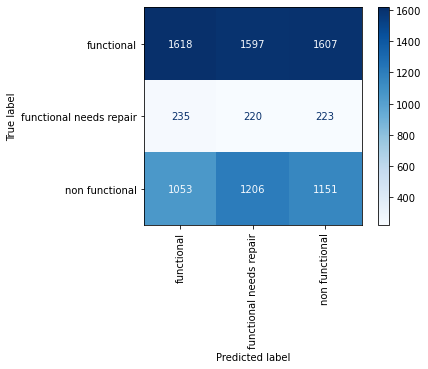

In [47]:
plot_confusion_matrix(dummyc, X_test, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Our stratified dummy classifier shows the weighted F1 score around .45 and less balanced accuracy. Dummy classifier is consistently wrong on all cases but recall for minority classes are especially bad.


## kNearestNeighbors
Now we will run K-Nearest Neighbors using GridSearchCV. 

### Scoring Function
Function to return weighted F1 and balanced accuracy score

In [48]:
def scoring(y_test, y_pred, text, scorer = scorer):
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    f1_test = round(f1_score(y_test, y_pred, average = 'macro'), 3)
    ck_test = round(cohen_kappa_score(y_test, y_pred), 3)
    print('Accuracy: ', accuracy, 'Test F1 score: ', f1_test, '/ Cohen Kappa: ', ck_test)
    scorer[text] = (accuracy, f1_test, ck_test)
    return scorer

### kNN with GridSearchCV

Finding the optimal value for K using GridSearchCV.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [102]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
knc_g.fit(X_train, y_train)
print(knc_g.best_params_, ': ', knc_g.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 26.2min finished


{'n_neighbors': 3} :  0.8045265348595214


In [103]:
# KNN performance on the test set
y_pred = knc_g.predict(X_test)
scoring(y_test, y_pred, 'knn gridsearch')
print(classification_report(y_test, y_pred))
# Accuracy:  0.745 Test F1 score:  0.633 / Cohen Kappa:  0.541
# Recall for functional needs repair: 0.36

Accuracy:  0.745 Test F1 score:  0.633 / Cohen Kappa:  0.541
                         precision    recall  f1-score   support

             functional       0.80      0.79      0.80      4822
functional needs repair       0.35      0.36      0.35       678
         non functional       0.75      0.75      0.75      3410

               accuracy                           0.75      8910
              macro avg       0.63      0.63      0.63      8910
           weighted avg       0.75      0.75      0.75      8910



In [104]:
# saving the model 
mod = open('PKL/knn_gsc.pkl', 'wb')
pickle.dump(knc_g.best_estimator_, mod)
mod.close()

In [ ]:
# Reload the model
#knc_g = pickle.load(open('PKL/knn_gsc.pkl', 'rb'))

### kNN with Optuna
Now we want to try different optimization method to make sure we have the best hyperparmeter for KNN. This time we'll use optuna to explore even more hyperparameters. We'll cap the time to what it took to be same as the time it took to complete GridSearch above.

In [49]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [51]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    #leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             #leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1))
    return (score)

# initiating the optuna study
#knn_study = optuna.create_study(direction='maximize')

# optimization process
#knn_study.optimize(find_hyperp_KNN, n_trials=1)

In [ ]:
# saving the study 
mod = open('PKL/knn_study.pkl', 'wb')
pickle.dump(knn_study, mod)
mod.close()

In [50]:
# Reload the study
knn_study = pickle.load(open('PKL/knn_study.pkl', 'rb'))

In [51]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(**knn_study.best_params, weights = 'distance', n_jobs = -1)
knc_opt.fit(X_train, y_train)

y_pred = knc_opt.predict(X_test)
scoring(y_test, y_pred, 'knn optuna')
print(classification_report(y_test, y_pred))
# Accuracy:  0.752 Test F1 score:  0.641 / Cohen Kappa:  0.553
# functional needs repair recall = 0.36

Accuracy:  0.752 Test F1 score:  0.641 / Cohen Kappa:  0.553
                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      4822
functional needs repair       0.36      0.36      0.36       678
         non functional       0.76      0.76      0.76      3410

               accuracy                           0.75      8910
              macro avg       0.64      0.64      0.64      8910
           weighted avg       0.75      0.75      0.75      8910



Recall score for the needs repair class is still low but the overall performance and the recall for non-functional improved slightly.

In [52]:
# saving the model
mod = open('PKL/knc_opt_model.pkl', 'wb')
pickle.dump(knc_opt, mod)
mod.close()

In [17]:
knc_study = pickle.load(open('PKL/knc_opt_model.pkl', 'rb'))

## Random Forest 
We will run random forest optimized by Optuna.

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700)
    #max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, X_train.shape[1])
    min_weight_fraction_leaf = trial.suggest_loguniform('min_weight_fraction_leaf', 1e-7, 0.1)
    max_leaf_nodes= trial.suggest_int('max_leaf_nodes', 10, 200)
    rfc = RandomForestClassifier(oob_score = True, 
                                 n_estimators = n_estimators,
                                 #max_depth = max_depth, 
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 criterion = criterion,
                                 class_weight = class_weight, 
                                 max_features = max_features,
                                 min_weight_fraction_leaf=min_weight_fraction_leaf,
                                 max_leaf_nodes = max_leaf_nodes
                                )
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train, y_train,
                                    scoring = 'accuracy', cv = cv, n_jobs = 4))
    return (score)

#rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, n_trials = 10)

[I 2020-08-29 11:10:01,548] Trial 155 finished with value: 0.7715574054804023 and parameters: {'n_estimators': 656, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 171, 'min_weight_fraction_leaf': 2.5986003060716383e-06, 'max_leaf_nodes': 156}. Best is trial 155 with value: 0.7715574054804023.
[I 2020-08-29 11:48:28,830] Trial 156 finished with value: 0.7710718002081165 and parameters: {'n_estimators': 655, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 174, 'min_weight_fraction_leaf': 2.421247637383259e-06, 'max_leaf_nodes': 155}. Best is trial 155 with value: 0.7715574054804023.
[I 2020-08-29 12:34:57,943] Trial 157 finished with value: 0.7709503988900451 and parameters: {'n_estimators': 652, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 212, 'min_weight_fraction

In [54]:
rf = RandomForestClassifier(oob_score = True, **rfc_study.best_params, n_jobs = -1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
scoring(y_test, y_pred_rf, 'random forest optuna')
print(classification_report(y_test, y_pred_rf))
# Accuracy:  0.74 Test F1 score:  0.642 / Cohen Kappa:  0.528
# functional needs repair recall = 0.45

Accuracy:  0.739 Test F1 score:  0.64 / Cohen Kappa:  0.528
                         precision    recall  f1-score   support

             functional       0.76      0.84      0.80      4822
functional needs repair       0.35      0.45      0.39       678
         non functional       0.83      0.66      0.73      3410

               accuracy                           0.74      8910
              macro avg       0.65      0.65      0.64      8910
           weighted avg       0.75      0.74      0.74      8910



Much better performance in predicting the positive minority cases even though overall F1 score has dropped slightly. This model seems to be weighing the minority recall better. 

In [23]:
# save the study
mod = open('PKL/rfc_study.pkl', 'wb')
pickle.dump(rfc_study, mod)
mod.close()

In [20]:
# Reload the study
#rfc_study = pickle.load(open('PKL/rfc_study.pkl', 'rb'))

In [55]:
# save the model
mod = open('PKL/rf_model.pkl', 'wb')
pickle.dump(rf, mod)
mod.close()

In [ ]:
#rf_model = pickle.load(open('PKL/rf_model.pkl', 'rb'))

In [56]:
# feature importance
rf_feats = pd.DataFrame(rf.feature_importances_,
                        index = new_feats,
                        columns=['feat_importance']).sort_values('feat_importance',ascending=False)
rf_feats.head(10)

,feat_importance
quantity_dry,0.1593
quantity_enough,0.0532
extraction_type_c_other,0.0511
longitude,0.0435
waterpoint_type_hand pump,0.0397
waterpoint_type_other,0.0365
quantity_insufficient,0.0358
lga_bariadi,0.0336
year_built_after05,0.0326
quantity_seasonal,0.0298


In [57]:
rf_feats.tail(10)

,feat_importance
installer_acra,0.0
scheme_management_trust,0.0
lga_sumbawanga urban,0.0
funder_unhcr,0.0
funder_villagers,0.0
source_unknown,0.0
installer_unicef,0.0
funder_water,0.0
lga_ludewa,0.0
lga_morogoro rural,0.0


## XGBoost
Now we'll try to run XGBoost with Optuna.

In [58]:
import xgboost as xgb

In [76]:
def find_hyperparam(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 1)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    #min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform('subsample', 0.4, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.01, 1.0)
    colsample_bylevel = trial.suggest_loguniform('colsample_bylevel', 0.01, 1.0)
    colsample_bynode = trial.suggest_loguniform('colsample_bynode', 0.01, 1.0)

    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             max_depth = max_depth, 
                             #min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             #sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                             colsample_bynode = colsample_bynode, 
                             colsample_bylevel = colsample_bylevel)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train, y_train, 
                                    scoring = 'accuracy', cv = cv, 
                                    n_jobs = -1))
    return (score)

#xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(find_hyperparam, timeout = 60*60, n_trials = 100)

[I 2020-08-29 23:44:13,347] Trial 133 finished with value: 0.8208463406174126 and parameters: {'eta': 0.4406484853286029, 'max_depth': 22, 'subsample': 0.5605334276779828, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.18404785484772998, 'colsample_bylevel': 0.7039789009061859, 'colsample_bynode': 0.08544926992361919}. Best is trial 109 with value: 0.8634061741241761.
[I 2020-08-29 23:47:38,691] Trial 134 finished with value: 0.8595907041276447 and parameters: {'eta': 0.36119348227329096, 'max_depth': 18, 'subsample': 0.5079194876308873, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.49693254851185814, 'colsample_bylevel': 0.4449910843315671, 'colsample_bynode': 0.9948275227899105}. Best is trial 109 with value: 0.8634061741241761.
[I 2020-08-29 23:48:43,943] Trial 135 finished with value: 0.8299167533818939 and parameters: {'eta': 0.11371039447029847, 'max_depth': 11, 'subsample': 0.43188241920432063, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.7

In [77]:
#Saving study
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()

In [78]:
xgb_study.optimize(find_hyperparam, timeout = 60*60)

[I 2020-08-30 00:47:40,374] Trial 152 finished with value: 0.8627818244883801 and parameters: {'eta': 0.20901443157388108, 'max_depth': 27, 'subsample': 0.6454705796184516, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.57920626068807, 'colsample_bylevel': 0.8419327562454327, 'colsample_bynode': 0.39170204559711025}. Best is trial 136 with value: 0.8638224072147068.
[I 2020-08-30 00:50:42,253] Trial 153 finished with value: 0.8623829344432881 and parameters: {'eta': 0.18448520753630662, 'max_depth': 26, 'subsample': 0.6617827364041515, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.33655820079803317, 'colsample_bylevel': 0.9821887257898622, 'colsample_bynode': 0.407232961221747}. Best is trial 136 with value: 0.8638224072147068.
[I 2020-08-30 00:56:17,502] Trial 154 finished with value: 0.8625216788067984 and parameters: {'eta': 0.13066545451136005, 'max_depth': 27, 'subsample': 0.6376923892497782, 'sampling_method': 'uniform', 'colsample_bytree': 0.782466839101

In [79]:
#Saving study
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()

In [80]:
xgb_study.optimize(find_hyperparam, timeout = 60*60)

[I 2020-08-30 01:56:59,656] Trial 170 finished with value: 0.8637703780783905 and parameters: {'eta': 0.26579606873510975, 'max_depth': 35, 'subsample': 0.8411252606461457, 'sampling_method': 'uniform', 'colsample_bytree': 0.6302547139403325, 'colsample_bylevel': 0.8303708827942395, 'colsample_bynode': 0.615979934424675}. Best is trial 136 with value: 0.8638224072147068.
[I 2020-08-30 02:03:21,530] Trial 171 finished with value: 0.8630593132154006 and parameters: {'eta': 0.2447083670087442, 'max_depth': 36, 'subsample': 0.8569780331597605, 'sampling_method': 'uniform', 'colsample_bytree': 0.5149523743658705, 'colsample_bylevel': 0.844397138319969, 'colsample_bynode': 0.6742574905402753}. Best is trial 136 with value: 0.8638224072147068.
[I 2020-08-30 02:07:26,436] Trial 172 finished with value: 0.8624002774887269 and parameters: {'eta': 0.28901684544232065, 'max_depth': 35, 'subsample': 0.847781587053561, 'sampling_method': 'uniform', 'colsample_bytree': 0.4720183676716282, 'colsample_

In [81]:
#Saving study
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()

In [82]:
xgb_study.optimize(find_hyperparam, timeout = 60*60)

[I 2020-08-30 02:56:02,818] Trial 180 finished with value: 0.8626257370794311 and parameters: {'eta': 0.15250619336696455, 'max_depth': 33, 'subsample': 0.9699865824570763, 'sampling_method': 'uniform', 'colsample_bytree': 0.620227746311205, 'colsample_bylevel': 0.7025882416300882, 'colsample_bynode': 0.5339353109736529}. Best is trial 179 with value: 0.8641866111689213.
[I 2020-08-30 03:04:13,543] Trial 181 finished with value: 0.8614637530350329 and parameters: {'eta': 0.3860032002396564, 'max_depth': 30, 'subsample': 0.9229564781341889, 'sampling_method': 'uniform', 'colsample_bytree': 0.7524480588199132, 'colsample_bylevel': 0.9955691429635786, 'colsample_bynode': 0.5938181733085145}. Best is trial 179 with value: 0.8641866111689213.
[I 2020-08-30 03:10:38,089] Trial 182 finished with value: 0.8639784946236558 and parameters: {'eta': 0.18797724932664234, 'max_depth': 28, 'subsample': 0.8837028731736397, 'sampling_method': 'uniform', 'colsample_bytree': 0.6446031915054233, 'colsampl

In [83]:
#Saving study
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()

In [84]:
# fitting and testing on the test set

xgbc = xgb.XGBClassifier(**xgb_study.best_params, verbosity=1, tree_method = 'gpu_hist')

xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)    
scoring(y_test, y_pred, 'xgboost')
print(classification_report(y_test, y_pred))

# Accuracy:  0.776 Test F1 score:  0.679 / Cohen Kappa:  0.595
# functional needs repair recall = 0.46

Accuracy:  0.776 Test F1 score:  0.679 / Cohen Kappa:  0.595
                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      4822
functional needs repair       0.40      0.46      0.43       678
         non functional       0.83      0.74      0.78      3410

               accuracy                           0.78      8910
              macro avg       0.68      0.68      0.68      8910
           weighted avg       0.78      0.78      0.78      8910



Top majority classes are doing so much better, but the minority class recall score dropped significantly from random forest model. We'll try to oversampling the minority classes and try again.

In [ ]:

# Reload the study
#xgb_study = pickle.load(open('PKL/xgb_study.pkl', 'rb'))

In [85]:
# saving model
mod = open('PKL/xgbc_model.pkl', 'wb')
pickle.dump(xgbc, mod)
mod.close()

In [ ]:
#xgbc_model = pickle.load(open('PKL/xgbc_model.pkl', 'rb'))

## Voting Classifier
Now I will try to run a voting classifier using some of the above models. Since many of the models did better with with minority classes oversampled, I will use oversampled data for voting.

In [86]:
from sklearn.ensemble import VotingClassifier

voting_c_soft = VotingClassifier(estimators = [
                                          ('knc_opt', knc_opt),
                                          ('rf', rf),
                                          ('xgbc', xgbc)
                                         ], 
                            voting = 'soft', 
                           n_jobs = -1)
voting_c_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('knc_opt',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=59, n_neighbors=3,
                                                   p=1, weights='distance')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_features=171,
                                                     max_leaf_nodes=156,
                                                     min_samples_split=3,
                                                     min_weight_fraction_leaf=2.5986003060716383e-06,
                                                     n_estimators=656,
                                                     n_jobs=-1,
                                                     oob_score=True)),
                             ('xgbc...
                                        

In [87]:
y_pred = voting_c_soft.predict(X_test)    
scoring(y_test, y_pred, 'voting')
print(classification_report(y_test, y_pred))

# Test F1 score:  0.77 / Test Accuracy:  0.671
# functional needs repair recall = 0.43

Accuracy:  0.79 Test F1 score:  0.688 / Cohen Kappa:  0.619
                         precision    recall  f1-score   support

             functional       0.82      0.85      0.83      4822
functional needs repair       0.43      0.43      0.43       678
         non functional       0.83      0.78      0.80      3410

               accuracy                           0.79      8910
              macro avg       0.69      0.69      0.69      8910
           weighted avg       0.79      0.79      0.79      8910



In [88]:
# save model
mod = open('PKL/voting_c_soft.pkl', 'wb')
pickle.dump(voting_c_soft, mod)
mod.close()

In [ ]:
# Reload the model
#voting_c_soft = pickle.load(open('PKL/voting_c_soft.pkl', 'rb'))

### Hard voting

In [89]:
voting_c_hard = VotingClassifier(estimators = [
                                          ('knc_opt', knc_opt),
                                          ('rf', rf),
                                          ('xgbc', xgbc)
                                         ], 
                            voting = 'hard', 
                           n_jobs = -1)
voting_c_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('knc_opt',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=59, n_neighbors=3,
                                                   p=1, weights='distance')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_features=171,
                                                     max_leaf_nodes=156,
                                                     min_samples_split=3,
                                                     min_weight_fraction_leaf=2.5986003060716383e-06,
                                                     n_estimators=656,
                                                     n_jobs=-1,
                                                     oob_score=True)),
                             ('xgbc...
                                        

In [90]:
y_pred = voting_c_hard.predict(X_test)    
scoring(y_test, y_pred, 'voting')
print(classification_report(y_test, y_pred))

# Test F1 score:  0.77 / Test Accuracy:  0.671
# functional needs repair recall = 0.43

Accuracy:  0.778 Test F1 score:  0.676 / Cohen Kappa:  0.596
                         precision    recall  f1-score   support

             functional       0.79      0.86      0.82      4822
functional needs repair       0.41      0.44      0.42       678
         non functional       0.85      0.73      0.78      3410

               accuracy                           0.78      8910
              macro avg       0.68      0.67      0.68      8910
           weighted avg       0.78      0.78      0.78      8910



In [91]:
# save model
mod = open('PKL/voting_c_hard.pkl', 'wb')
pickle.dump(voting_c_hard, mod)
mod.close()

In [ ]:
# Reload the model
#voting_c_hard = pickle.load(open('PKL/voting_c_hard.pkl', 'rb'))

### Soft with more weights to XGBoost

In [92]:
voting_c_soft_w = VotingClassifier(estimators = [
                                          ('knc_opt', knc_opt),
                                          ('rf', rf),
                                          ('xgbc', xgbc)
                                         ], 
                            voting = 'soft', weights = [1, 1, 1.5],
                           n_jobs = -1)
voting_c_soft_w.fit(X_train, y_train)

VotingClassifier(estimators=[('knc_opt',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=59, n_neighbors=3,
                                                   p=1, weights='distance')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_features=171,
                                                     max_leaf_nodes=156,
                                                     min_samples_split=3,
                                                     min_weight_fraction_leaf=2.5986003060716383e-06,
                                                     n_estimators=656,
                                                     n_jobs=-1,
                                                     oob_score=True)),
                             ('xgbc...
                                        

In [93]:
y_pred = voting_c_soft_w.predict(X_test)    
scoring(y_test, y_pred, 'voting')
print(classification_report(y_test, y_pred))

# Test F1 score:  0.77 / Test Accuracy:  0.671
# functional needs repair recall = 0.43

Accuracy:  0.789 Test F1 score:  0.688 / Cohen Kappa:  0.618
                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      4822
functional needs repair       0.43      0.44      0.43       678
         non functional       0.83      0.77      0.80      3410

               accuracy                           0.79      8910
              macro avg       0.69      0.69      0.69      8910
           weighted avg       0.79      0.79      0.79      8910



In [94]:
# save model
mod = open('PKL/voting_c_soft_w.pkl', 'wb')
pickle.dump(voting_c_soft_w, mod)
mod.close()

In [ ]:
# Reload the model
#voting_c_soft = pickle.load(open('PKL/voting_c_soft.pkl', 'rb'))

In [97]:
from sklearn.linear_model import SGDClassifier

In [107]:
SGDC = SGDClassifier(loss = 'log', penalty='elasticnet', 
                     max_iter=1000, tol=1e-3)
SGDC.fit(X_train, y_train)
y_pred = SGDC.predict(X_test)
scoring(y_test, y_pred, 'SGDC')


Accuracy:  0.721 Test F1 score:  0.609 / Cohen Kappa:  0.5


{'dummy': (0.33, 0.294, -0.006),
 'knn optuna': (0.752, 0.641, 0.553),
 'random forest optuna': (0.739, 0.64, 0.528),
 'xgboost': (0.776, 0.679, 0.595),
 'voting': (0.789, 0.688, 0.618),
 'SGDC': (0.721, 0.609, 0.5)}

In [111]:
feat_importance = pd.DataFrame(SGDC.coef_.T, columns = SGDC.classes_, index = new_feats)

In [118]:
feat_importance.sort_values(by = 'functional needs repair', ascending = False).head(10)

,functional,functional needs repair,non functional
zero_gps_height,-0.1149,0.7935,-0.5102
extraction_type_c_gravity,1.1832,0.7132,-0.5590
region_kigoma,-0.1515,0.4531,-0.1545
region_singida,0.2190,0.4333,-0.8397
gps_height,0.0000,0.4161,-0.2863
region_morogoro,0.4695,0.4074,-0.3351
district_code_1,0.3417,0.3743,-0.3276
lga_bukombe,-0.0472,0.3176,-0.1185
lga_bariadi,0.0000,0.2991,0.0000
extraction_type_c_submersible,0.6848,0.2924,-0.3025
